# DTD cross-validation results

This notebook analyzes the cross-validation results of the 3D DTD model on the
killifish data (including featurization, HMM fitting, and binning) from 2023-07-26.
This latest dataset of binned counts consists of a 14410 days of recording (across ~70 fish),
with 144 time bins (at 10 minute intervals), for 100 behavioral syllables.
The goal is to find the most parsimonious model (i.e. choice of rank $(K_1, K_2, K_3)$.
which best fits the data.

The evaluated metric is the percentage deviation of the held-out log likelihood under the fitted model, $\hat{\ell}$,
from the held-out log likelihood under an optimal model that uses the true empirical syllable usage, $\ell^{*}$.
Both of these log likelihoods are taken relative to the baseline model that assumes
average syllable given the held-in samples, $\ell^\circ$.
This metric is given as follows:
$$
\mathcal{C} = \frac{\hat{\ell} - \ell^\circ}{\ell^{*} - \ell^\circ}.
$$
This value is correlated with the held-out log likelihood but is independent of model rank.
A higher value of $C$ is closer to the optimal value.

The below results are fit with full-batch EM for 2500 iterations on an 80GB A100 GPU.
The validation set consists of 20% of events (i.e. distribution over syllables) held out at random. The sweep parameters are found in the file `analysis/_kf_cv_config.yaml`

**TO DO**
- [ ] Evaluate run time as a function of rank complexity
- [ ] Ensure that all runs have ~5 runs
- [ ] Perhaps we should change the name "percent deviation" so that is more consistent with high we use it...higher value is good.

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd 
import numpy as np
import wandb
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

## Get CV results

Pull data from WandB server into a Pandas dataframe.

In [8]:
def get_results_df(entity, project, config_keys, summary_keys):
    """Project is specified by <entity/project-name>"""
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(f"{entity}/{project}")

    run_results = {key: [] for key in itertools.chain(['id', 'name'], config_keys, summary_keys)}

    for run in runs: 

        # .summary contains the output keys/values for metrics like accuracy.
        # use .get to catch NaN runs (e.g. due to OOM)
        for key in summary_keys:
            run_results[key].append(run.summary.get(key,))

        # .config contains the hyperparameters.
        for key in config_keys:
            run_results[key].append(run.config[key])

        # .name is the human-readable name
        run_results['name'].append(run.name)
        run_results['id'].append(run._attrs['name'])

    return pd.DataFrame(run_results)

# Project is specified by <entity/project-name>
wnb_entity = 'eyz'
wnb_project = 'kf-dtd-231022'

config_keys = ['k1', 'k2', 'k3']
summary_keys = ['pct_dev']

df = get_results_df(wnb_entity, wnb_project, config_keys, summary_keys)

In [9]:
# Focus on k2 < 10
df = df[(df['k2'] < 9) & (df['k2']!=7) &(df['k3'] <= 70)]

# Drop rows that have NaN pct_dev
df = df.dropna(axis=0)

## Evaluate validation metric as a function of rank

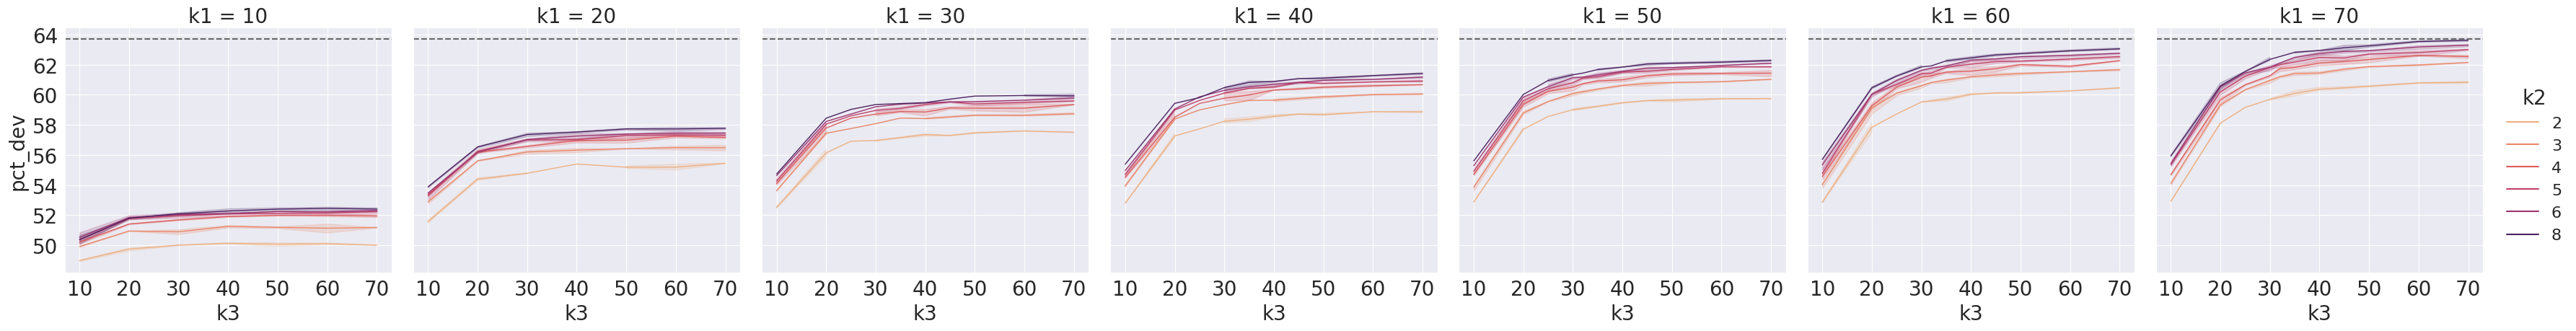

In [13]:
best_idx = df['pct_dev'].argmax()
best_rank = tuple(df.iloc[best_idx][['k1','k2','k3']])
best_pct_dev = df.iloc[best_idx]['pct_dev']

with plt.rc_context({'font.size': 20,
                     'legend.fontsize': 16}):
    sns.set_style('darkgrid')
    g = sns.relplot(df,  x='k3', y='pct_dev', col='k1', hue='k2', col_wrap=7, palette='flare', kind='line', legend='full', lw=1,);
    for ax in g.axes:
        ax.axhline(y=best_pct_dev, ls='--', c='0.4')
        # ax.set_ylim(48, 68)
        # ax.set_yscale('log')
    
# g.figure.suptitle(f'highest pct_dev: {best_pct_dev:.1f}, K={best_rank}', y=1.04)


Since we expect the validation metric to increase with greater model complexity
(a value of `pct_dev = 100` is achieved when $(K_1, K_2, K_3) = (D_1, D_2, D_3)$),
we seek the most parsimonious model. We choose this model by evaluating where "elbow"
of the curves, such that increasing rank provides diminishing returns on percent deviation.

We find that there is very later variance in the models
**(based on analysis from initial set of runs, n=5; but this needs to be RE-VERIFiED
because many current runs only use n=1-2)**.

The above plots provide us with an effective qualitive understanding of the range in
which the most parsimonious model exists. Below, we evaluate the relative improvement
by an unit increase in rank, per mode.

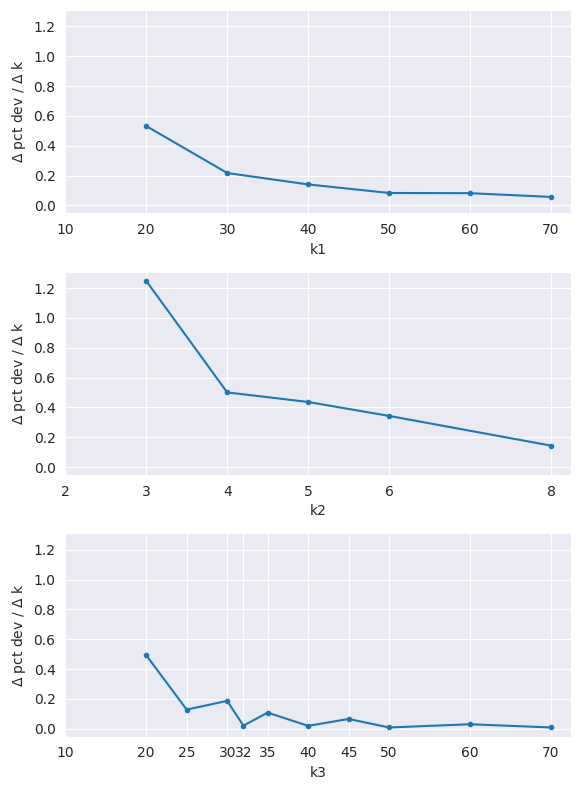

In [16]:
fig, axs = plt.subplots(3, 1, sharey=True, figsize=(6,8))

for ax, kref in zip(axs, ['k1','k2','k3']):
    ks = np.array(sorted(df[kref].unique()))
    max_by_k = np.array([df.loc[df[kref]==k]['pct_dev'].max() for k in ks])

    ax.plot(ks[1:], (max_by_k[1:]-max_by_k[:-1])/(ks[1:]-ks[:-1]), ls='-', marker='.')
    # ax.plot(ks[1:], max_by_k[1:]-max_by_k[:-1]), ls='-', marker='.')
    ax.set_xticks(ks)
    ax.set_xticklabels(ks)
    ax.set_xlabel(kref)

    # ax.set_ylabel(r'$\Delta$ pct dev / $\Delta$ k')
axs[0].set_ylabel(r'$\Delta$ pct dev / $\Delta$ k')

fig.tight_layout()
# fig.suptitle('normalized pct dev increase of rank')



**TO DO: REMOVE BELOW PLOT, AFTER VERIFYING THAT ABOVE PLOTS LOOK SMOOTHER AFTER ENSURING ALL RUNS COMPLETED...**

Text(0.5, 0.98, 'pct dev increase of rank relative to prev rank')

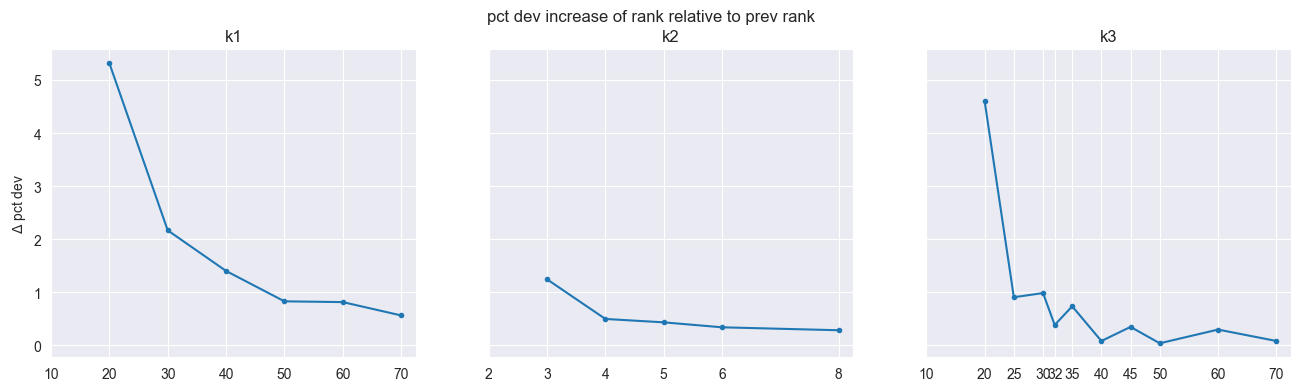

In [222]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(16,4))

for ax, kref in zip(axs, ['k1','k2','k3']):
    ks = np.array(sorted(df[kref].unique()))
    max_by_k = np.array([df.loc[df[kref]==k]['pct_dev'].max() for k in ks])

    ax.plot(ks[1:], np.abs(max_by_k[1:]-max_by_k[:-1]), ls='-', marker='.')

    ax.set_xticks(ks)
    ax.set_xticklabels(ks)
    ax.set_title(kref)

axs[0].set_ylabel(r'$\Delta$ pct dev')

fig.suptitle('pct dev increase of rank relative to prev rank')


## Bookeeping : Ensure 5-fold cross-validation

Text(0.5, 1.0, '# runs per model rank')

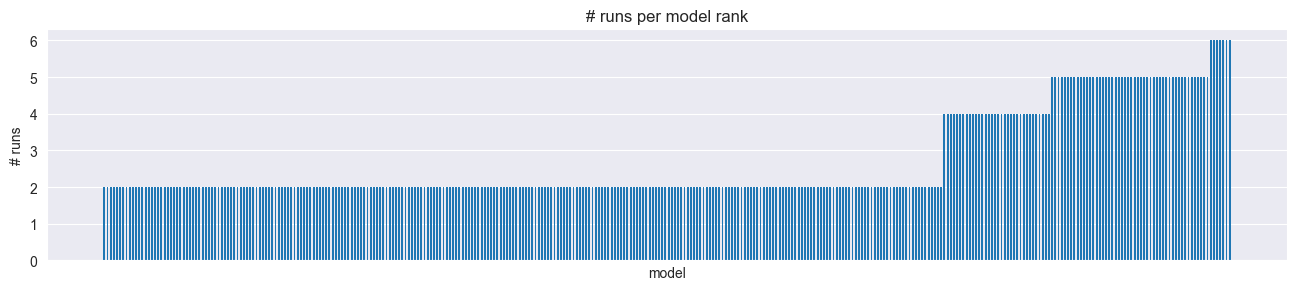

In [221]:
all_ranks = np.stack([df['k1'], df['k2'], df['k3']], axis=-1)
unique_ranks, n_runs_per_rank = np.unique(all_ranks, return_counts=True, axis=0)
assert len(all_ranks) > len(unique_ranks), f'Expected n>1 run for at least one rank; currently have {len(unique_ranks)} unique ranks out of {len(all_ranks)} runs.'

# Sort unique ranks and runs in ascending order
i_sort = np.argsort(n_runs_per_rank)
n_runs_per_rank = n_runs_per_rank[i_sort]
unique_ranks = unique_ranks[i_sort]

# --------------------------------------------
# Plot summary figure

fig = plt.figure(figsize=(16,3))
plt.bar(np.arange(len(unique_ranks)), n_runs_per_rank, width=0.6, ec='none')
plt.xticks([])
plt.xlabel('model')
plt.ylabel('# runs')
plt.title('# runs per model rank')

In [217]:
for r, n in zip(unique_ranks, n_runs_per_rank):
    if n == 5: continue

    print(f'{r}\t{n}')

[50  3 40]	1
[60  3 70]	1
[60  3 60]	1
[60  3 50]	1
[60  3 40]	1
[60  3 30]	1
[60  3 20]	1
[60  3 10]	1
[40  3 70]	1
[70  3 10]	1
[70  3 20]	1
[70  3 30]	1
[70  3 40]	1
[70  3 50]	1
[70  3 70]	1
[70  3 60]	1
[50  3 30]	1
[50  3 50]	1
[50  3 60]	1
[50  3 70]	1
[50  3 20]	1
[50  3 10]	1
[50  4 40]	2
[60  2 40]	2
[60  2 45]	2
[60  2 50]	2
[50  2 50]	2
[50  2 45]	2
[50  2 40]	2
[50  2 35]	2
[50  2 30]	2
[60  4 10]	2
[60  4 20]	2
[60  4 30]	2
[60  4 35]	2
[60  4 40]	2
[60  4 45]	2
[60  4 50]	2
[60  2 35]	2
[60  2 30]	2
[50  8 70]	2
[60  2 10]	2
[50  4 45]	2
[50  4 50]	2
[50  5 35]	2
[50  5 45]	2
[50  5 60]	2
[50  5 70]	2
[50  6 35]	2
[50  6 45]	2
[60  2 20]	2
[50  6 60]	2
[50  8 35]	2
[50  8 45]	2
[50  4 30]	2
[60  5 10]	2
[50  4 20]	2
[50  4 10]	2
[50  8 60]	2
[50  4 35]	2
[50  6 70]	2
[60  5 20]	2
[60  5 45]	2
[60  5 35]	2
[70  4 40]	2
[70  4 45]	2
[70  4 50]	2
[70  5 10]	2
[70  5 20]	2
[70  5 30]	2
[70  5 35]	2
[70  5 40]	2
[70  5 45]	2
[70  5 50]	2
[70  6 10]	2
[70  4 35]	2
[70  6 20]	2